In [2]:
from struct_pop import *
import matplotlib.pyplot as plt
plt.style.use('default')

This notebook illustrates the use of the code _struct_pop.py_, to model the evolution of structured populations, in a serial dilution model. 

This code was used to generate figures in the paper _Frequent asymmetric migrations suppress natural selection in spatially structured populations_, by Alia Abbara and Anne-Florence Bitbol, and _Mutant fate in spatially structured populations on graphs: connecting models to experiments_ by Alia Abbara, Lisa Pagani, Celia García-Pareja, and Anne-Florence Bitbol.

## Illustration of the code on the star graph

### Examples for elementary functions


We start with a star graph with 4 demes. Its state is tracked by an array containing the number of mutant and wild-type indivudals that are in each deme. The first entry describes the center, the other describe the leaves.

For example, $[[1,99],[0,100],[0,100],[0,100]]$ means:
- the center contains one mutant and 99 wild-types
- the leaves contain 100 mutants each.

In [7]:
#Initial state of the star
in_numbers=np.array([[1.,99.],[0.,100.],[0.,100.],[0.,100.]]).astype(np.int64)
    
#Parameters
mO=0.01
mI=0.04
s=0.01
fitnesses=np.array([1+s,1])
nb_cycles=1000
t=5
N_demes=4
K=100
folder=None

The graph structure and its migration rates are specified through function migration_matrix. 
For a star, we use the function 'define_star', which takes parameters $m_O$ (outgoing migration rate from the center) and $m_I$ (ingoing migration rate in the center). The option "equal_contribution" is True if for each deme $i$, $\sum_j m_{ij}=1$ i.e. all demes contribute equally in average. It is False if for each deme $i$, $\sum_j m_{ji}=1$ i.e. all demes receive the same contribution in average.

In [8]:
#Migration matrix of the star
migration_matrix=define_star(N_demes,mI,mO, equal_contribution=True)

Building blocks of the code: 
'growth_event' models the exponential growth in each deme, 'dilution_migration_event' models the dilution and migration step.

In [9]:
#Examples of individual functions
grown_numbers=growth_event(in_numbers,fitnesses,t)
print('Graph state after growth: \n', grown_numbers)
diluted_numbers=dilution_migration_event(grown_numbers,migration_matrix,K)
print('\n Graph state after dilution and migration: \n', diluted_numbers)

Graph state after growth: 
 [[  156.02246449 14692.90275116]
 [    0.         14841.31591026]
 [    0.         14841.31591026]
 [    0.         14841.31591026]]

 Graph state after dilution and migration: 
 [[  0 110]
 [  0 118]
 [  0 111]
 [  0  97]]


'fixation_probability' runs a number 'nb_sim' of simulations. For each simulation, it starts with the initial state of the graph, and iterates cycles of growth/dilution, until the mutants are fixed or extinct.  The function returns three numbers :
- the average extinction time (computed on trajectories that ended in extinction)
- the average fixation time (computed on trajectories that ended in fixation)
- the ratio of fixations, i.e. probability of fixation

'fixation_probability' has an option 'save_dynamics'. If True, it saves the evolution of the state of the graph, for each simulation separately, into a folder specified as argument.

In [10]:
#Fixation probability computed on 1000 simulations
nb_sim=1000
et, ft, fp = fixation_probability(in_numbers, folder, migration_matrix, fitnesses, nb_sim, nb_cycles, t, K, size_follow_numbers=100, print_frequency=500, save_dynamics=False)
print(f'Fixation probability on {nb_sim} simulations is {fp}, with \n average extinction time {et} and \n average fixation time {ft}')

Fixation probability on 1000 simulations is 0.04, with 
 average extinction time 4.159375 and 
 average fixation time 209.425


### Fitness vs fixation probability plot

In [48]:
#Parameters of the graph
mO=0.1
mI=0.4
N_demes=5
#Migration matrix of the star graph, when all demes have the same bottleneck size on average
migration_matrix=define_star(N_demes,mI,mO, equal_contribution=False)

#Array of fitnesses
s_array=np.linspace(-0.001,0.05,10)
fixation_probas=[]

#Fixation probability for each fitness
for s in s_array:

    #Initial state: one mutant placed in a leaf
    in_numbers=np.array([[0.,100.],[0.,100.],[1.,99.],[0.,100.],[0.,100.]]).astype(np.int64)
    fitnesses=np.array([1+s,1])
    #Number of simulations for each point
    nb_sim=5000
    nb_cycles=10000
    #Growth phase duration and bottleneck size
    t=5
    K=100
    folder='None'
    et, ft, fp = fixation_probability(in_numbers, folder, migration_matrix, fitnesses, nb_sim, nb_cycles, t, K, size_follow_numbers=1000, print_frequency=1, save_dynamics=False)
    fixation_probas.append(fp)

Text(0, 0.5, 'Fixation probability')

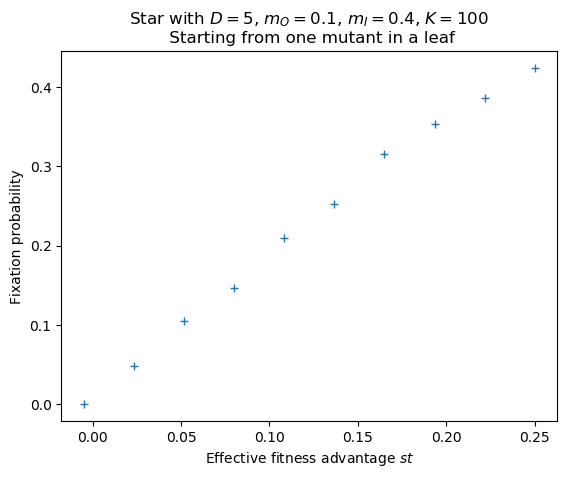

In [49]:
plt.plot(s_array*5, fixation_probas, linestyle='None', marker='+')
plt.title('Star with $D=5$, $m_O=0.1$, $m_I=0.4$, $K=100$ \n Starting from one mutant in a leaf')
plt.xlabel('Effective fitness advantage $st$')
plt.ylabel('Fixation probability')

## Illustration of the code on Dirichlet cliques

### Generating a Dirichlet clique with an advantaged deme

In [50]:
#Adjacency matrix that defines the clique structure
adj=np.ones((5,5))

#Defining Dirichlet parameters
eta0=20
als=np.ones((5,5))
als[0]=np.array([1,eta0,eta0,eta0,eta0])

#Generating a Dirichlet clique with an advantaged deme
dirichlet_matrix=random_graph(adj,convention='eqsize',alpha_values=als)
print("Example of a randomly generated Dirichlet clique with one advantaged deme, with eta0=20 : \n", dirichlet_matrix)

Example of a randomly generated Dirichlet clique with one advantaged deme, with eta0=20 : 
 [[0.03580345 0.74163305 0.85998467 0.93204133 0.72473761]
 [0.1011483  0.01125024 0.00331649 0.03142912 0.01135284]
 [0.53505235 0.04494007 0.10573986 0.01397865 0.10793061]
 [0.03943151 0.13178782 0.00465847 0.01092905 0.04126615]
 [0.28856439 0.07038883 0.02630051 0.01162186 0.11471279]]


### Comparing the probability of fixation of a mutant in a Dirichlet clique with a standard clique

In [51]:
#Migration matrix of a standard clique
N_demes=5
m=1/5
clique_matrix=define_clique(N_demes,m)

#Array of fitnesses
s_array=np.linspace(-0.001,0.05,10)
fixation_probas_clique=[]
fixation_probas_dirichlet=[]

#Fixation probability for each fitness
for s in s_array:

    #Initial state: one mutant placed in a leaf (the one advantaged in the Dirichlet clique)
    in_numbers=np.array([[1.,99.],[0.,100.],[0.,100.],[0.,100.],[0.,100.]]).astype(np.int64)
    fitnesses=np.array([1+s,1])
    #Number of simulations for each point
    nb_sim=2000
    nb_cycles=10000
    t=5
    K=100
    folder='None'
    #Fixation probability computed on 2000 simulations for the standard clique and the Dirichlet clique
    et_clique, ft_clique, fp_clique = fixation_probability(in_numbers, folder, clique_matrix, fitnesses, nb_sim, nb_cycles, t, K, size_follow_numbers=1000, print_frequency=1, save_dynamics=False)
    et_dirichlet, ft_dirichlet, fp_dirichlet = fixation_probability(in_numbers, folder, dirichlet_matrix, fitnesses, nb_sim, nb_cycles, t, K, size_follow_numbers=1000, print_frequency=1, save_dynamics=False)
    fixation_probas_clique.append(fp_clique)
    fixation_probas_dirichlet.append(fp_dirichlet)


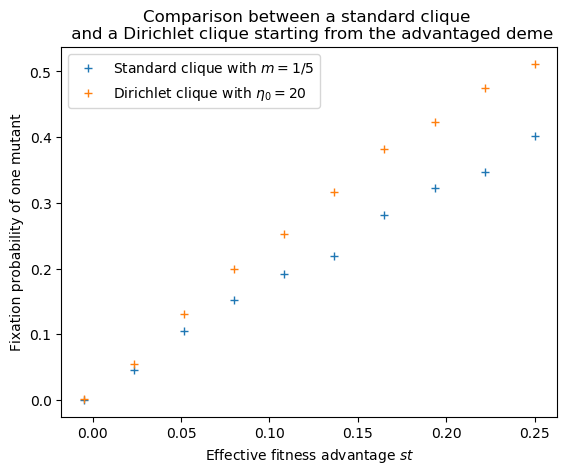

In [46]:
plt.plot(s_array*5, fixation_probas_clique, linestyle='None', marker='+', label='Standard clique with $m=1/5$')
plt.plot(s_array*5, fixation_probas_dirichlet, linestyle='None', marker='+', label='Dirichlet clique with $\eta_0=20$')
plt.title('Comparison between a standard clique \n and a Dirichlet clique starting from the advantaged deme')
plt.xlabel('Effective fitness advantage $st$')
plt.ylabel('Fixation probability of one mutant')
plt.legend()